In [25]:
import matplotlib.pyplot as plt
import numpy as np
import math
from tensorflow.keras.datasets import fashion_mnist

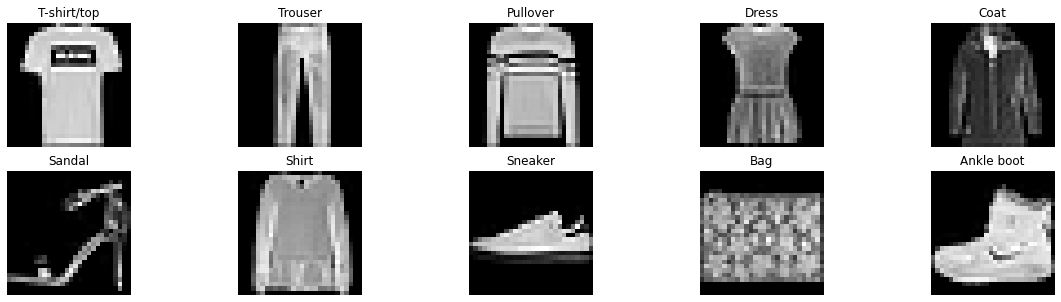

In [26]:
(x_train, y_train), (x_test, y_test)= fashion_mnist.load_data()
x_train , x_test = x_train/255.0, x_test/255.0
classes= {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
target_list = []

plt.figure(figsize=(20, 5))

for i in range(len(x_train)):
    if y_train[i] not in target_list:
        target_list.append(y_train[i])
        sample = x_train[i]
        target = y_train[i]
        
        plt.subplot(2, 5, y_train[i]+1)
        plt.axis('off')
        plt.imshow(sample, cmap='gray')
        plt.title(f'{classes[target]}')
plt.show()

In [27]:
# Activation Functions
def sigmoid(X):
    A = 1/(1+np.exp(-X))
    return A

def relu(X):
    A = np.maximum(0,X)
    
    assert(A.shape == X.shape)
    return A

def relu_grad(dA,A):
    dX = np.array(dA, copy=True)
    dX[A<=0] = 0
    
    assert (dX.shape == A.shape)
    return dX

def sigmoid_grad(dA,A):
    dX = dA * A* (1-A)
    return dX

def softmax(X):
    A=np.exp(X)
    A = A/np.sum(A, axis=0, keepdims=True)
    return A

def act_fn(X,activation):
    if activation == "sigmoid":
        return sigmoid(X) 

    elif activation == "relu":
        return relu(X)

    elif activation == "softmax":
        return softmax(X)
    else:
        print("Please include the fn first")
            
def act_fn_grad(dA, A, activation_name):
    # Returns dX
    if activation_name == "relu":
        return relu_grad(dA, A)

    elif activation_name == "sigmoid":
        return sigmoid_grad(dA, A)

In [28]:
def class_onehot(indices, num_classes , zero_indexed=True): # Takes class number [0,classes-1] and returns one hot (zero indexed)
    if zero_indexed:
        return np.identity(num_classes)[np.array(indices)].T
    else :
        return np.identity(num_classes)[np.array(indices-1)].T

In [29]:
# Loss Functions
def cross_entropy_sigmoid(y, y_pred):
#     print(y.shape)
    m = y.shape[0]
    cost = -1/m * np.sum(y * np.log(y_pred) + (1-y) * np.log(1-y_pred))
#     cost = -1/m * np.sum(np.multiply(np.log(y_pred), y) + np.multiply(np.log(1-y_pred), (1-y)))
#     cost = np.squeeze(cost)
    return cost

def cross_entropy_sigmoid_grad(y, y_pred):
    m = y.shape[1]
    return -(np.divide(y, y_pred) - np.divide(1 - y, 1 - y_pred))

def mean_squared(y, y_pred):
    return  np.sum((y - y_pred)**2 ).squeeze() / (y_pred.shape[1]*2)

def mean_squared_grad(y, y_pred):
    return (y_pred - y)

def cross_entropy_softmax(y,y_pred,one_hot=True,zero_indexed_classes=True, classes=10):
    if one_hot:
        return np.sum(np.array(y)*(-1*np.log(y_pred)))
    else:
        # classes should begin with zero index or else change one_hot_fn
        return np.sum(class_onehot(y,classes,zero_indexed=zero_indexed_classes)*(-1*np.log(y_pred)))

def cross_entropy_softmax_grad(y,y_pred,one_hot=True,zero_indexed_classes=True, classes=10):
    if one_hot:
        return np.array(y)*(-1/y_pred)
    else:
        # classes should begin with zero index or else change one_hot_fn
        return class_onehot(y,classes,zero_indexed=zero_indexed_classes)*(-1/y_pred)

In [30]:
def cost_fn(y,y_pred, output_activation="sigmoid", loss_fn="cross_entropy"):
    if output_activation=="sigmoid" and loss_fn=="cross_entropy":
        return cross_entropy_sigmoid(y, y_pred)
    elif output_activation=="softmax" and loss_fn=="cross_entropy":
        return cross_entropy_softmax(y,y_pred)
    elif output_activation=="linear" and loss_fn=="mse":
        return mean_squared(y, y_pred)

In [31]:
def output_exc_act_grad(y,y_pred, output_activation="sigmoid", loss_fn="cross_entropy", classes=10):
    if output_activation=="sigmoid" and loss_fn=="cross_entropy":
        return y_pred-y
    elif output_activation=="softmax" and loss_fn=="cross_entropy":
        y=class_onehot(y,classes)
        return y_pred-y 
    elif output_activation=="linear" and loss_fn=="mse":
        return y - y_pred

In [32]:
class FeedForward_NN:
    def __init__(self, input_features, hidden_layers_dims=[784], output_nodes=1):

        self.hL = len(hidden_layers_dims)
        self.output_nodes = output_nodes
        self.layer_dims = [input_features] + hidden_layers_dims + [output_nodes] # list with all layer sizes (including input and output)
        
        ## Weight Initialization
        self.params = {}
        L = len(self.layer_dims) # total number of layers in the network

        for l in range(1, L):
            self.params['W' + str(l)] = np.random.randn(self.layer_dims[l], self.layer_dims[l-1]) * 0.01
            self.params['b' + str(l)] = np.zeros((self.layer_dims[l], 1))
        
        self.L = len(self.params) // 2 # number of layers in the neural network
        self.caches=[] # stores tuple of X_W (W, X) and activation cache for each layer
        self.grads = {} # it is storing all the partial derivatives i.e. dX, db and dW
    
    def forward_prop(self, X):
     
        self.caches.clear() # self.caches stores tuple of X_W and activation cache for each layer
        
        for l in range(1, self.L):
            W = self.params['W%d' % l]
            b = self.params['b%d' % l]
            
            self.caches.append(X)
            X = np.dot(W , X) + b
            A = act_fn(X,'relu')
            
            X = A # current activation will act as input for next layer
        
        self.caches.append(X)
        ## last layer activation and cache done seperately because different activation functions used
        W = self.params['W%d' % self.L]
        b = self.params['b%d' % self.L]
        
        X = np.dot(W , X) + b
        return X
    
    
    def backward_prop(self,dX): # dX is derivaltive of loss fn wrt last layer X i.e, X = W_L @ A_L-1 + b_L
        self.grads.clear()
        m = dX.shape[1]
        
        # Now you know partial derivative of last layer activation wrt loss, calculate the weights, biases and L-1 layer activation gradients 
        A_prev = self.caches[self.L-1] # caches stores activations of all layer(last layer not required) + input
        
        W = self.params["W"+str(self.L)]
        
        self.grads["dW" + str(self.L)] = 1 / m * np.dot(dX , A_prev.T)
        self.grads["db" + str(self.L)] = 1 / m * np.sum(dX, axis=1, keepdims=True)
        self.grads["dA" + str(self.L-1)] = np.dot(W.T , dX)
        
        for l in reversed(range(self.L-1)):
            A_prev = self.caches[l]
            W = self.params["W"+str(l+1)]
            
            dX = act_fn_grad(self.grads["dA" + str(l + 1)], A_prev, 'relu') # in first iteration it is dx_L-1
                                                                            # use dX_L-1 to find dW_L-1, db_L-1 and dA_L-2
            self.grads["dW" + str(l+1)] = 1 / m * np.dot(dX , A_prev.T)
            self.grads["db" + str(l+1)] = 1 / m * np.sum(dX, axis=1, keepdims=True)
            self.grads["dA" + str(l)] = np.dot(W.T , dX)
          

    #stochastic gradient descent(sgd)
    def init_sgd(self):
        pass
    def update_sgd_params():
        pass
    
    
    # momentum based gradient descent
    def init_moment(self):
        v={}
        
        for l in range(self.L):
            v["dW" + str(l+1)] = np.zeros(self.params["W" + str(l+1)].shape)
            v["db" + str(l+1)] = np.zeros(self.params["b" + str(l+1)].shape)
        
        return v
        
    def update_moment_params(self, v, beta, learning_rate):
        
        for l in range(self.L):
            v["dW" + str(l+1)] = (beta * v["dW" + str(l+1)]) + ((1 - beta)*self.grads["dW" + str(l+1)])
            v["db" + str(l+1)] = (beta * v["db" + str(l+1)]) + ((1 - beta)*self.grads["db" + str(l+1)])

            self.params["W" + str(l+1)] = self.params["W" + str(l+1)] - (learning_rate * v["dW" + str(l+1)])
            self.params["b" + str(l+1)] = self.params["b" + str(l+1)] - (learning_rate * v["db" + str(l+1)])
    
    #rmsprop
    def init_rmsprop(self):
        s={}
        for l in range(self.L):
            s["dW" + str(l+1)] = np.zeros(self.params["W" + str(l+1)].shape)
            s["db" + str(l+1)] = np.zeros(self.params["b" + str(l+1)].shape)
        
        return s
        
    def update_rmsprop_params(self, s, beta):
        
        for l in range(self.L):
            s["dW" + str(l+1)] = (beta * s["dW" + str(l+1)]) + ((1-beta)*np.power(self.grads["dW"+str(l+1)], 2))
            s["db" + str(l+1)] = (beta * s["db" + str(l+1)]) + ((1-beta)*np.power(self.grads["db"+str(l+1)], 2))

            self.params["W" + str(l+1)] = self.params["W" + str(l+1)] - (learning_rate * self.grads["dW" + str(l+1)])/np.sqrt(s["dW"+str(l+1)])
            self.params["b" + str(l+1)] = self.params["b" + str(l+1)] - (learning_rate * self.grads["db" + str(l+1)])/np.sqrt(s["db"+str(l+1)])
    
    # adam
    def init_adam(self):
        v={}
        s={}
        
        for l in range(self.L):
            v["dW" + str(l+1)] = np.zeros(self.params["W" +str(l+1)].shape)
            v["db" + str(l+1)] = np.zeros(self.params["b" +str(l+1)].shape)
            s["dW" + str(l+1)] = np.zeros(self.params["W" +str(l+1)].shape)
            s["db" + str(l+1)] = np.zeros(self.params["b" +str(l+1)].shape)
        
        return v, s
        
    def update_adam_params(self, v, s, t, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-7):
        v_corrected = {}
        s_corrected = {}
        
        for l in range(self.L):
            v["dW" + str(l+1)] = (beta1 * v["dW" + str(l+1)]) + ((1-beta1)*(self.grads["dW"+str(l+1)]))
            v["db" + str(l+1)] = (beta1 * v["db" + str(l+1)]) + ((1-beta1)*(self.grads["db"+str(l+1)]))
            
            v_corrected["dW" + str(l+1)] = v["dW"+str(l+1)]/(1-np.power(beta1, t))
            v_corrected["db" + str(l+1)] = v["db"+str(l+1)]/(1-np.power(beta1, t))
            
            s["dW" + str(l+1)] = (beta2 * s["dW" + str(l+1)]) + ((1-beta2)*np.power(self.grads["dW"+str(l+1)], 2))
            s["db" + str(l+1)] = (beta2 * s["db" + str(l+1)]) + ((1-beta2)*np.power(self.grads["db"+str(l+1)], 2))
            
            s_corrected["dW" + str(l+1)] = s["dW"+str(l+1)]/(1-np.power(beta2, t))
            s_corrected["db" + str(l+1)] = s["db"+str(l+1)]/(1-np.power(beta2, t))
            
            self.params["W" + str(l+1)] = self.params["W"+str(l+1)] - learning_rate*(v_corrected["dW"+str(l+1)]/np.sqrt(s_corrected["dW"+str(l+1)]+epsilon))
            self.params["b" + str(l+1)] = self.params["b"+str(l+1)] - learning_rate*(v_corrected["db"+str(l+1)]/np.sqrt(s_corrected["db"+str(l+1)]+epsilon))
    
    # nadam
    def init_nadam(self):
        v={}
        s={}
        
        for l in range(self.L):
            v["dW" + str(l+1)] = np.zeros(self.params["W" +str(l+1)].shape)
            v["db" + str(l+1)] = np.zeros(self.params["b" +str(l+1)].shape)
            s["dW" + str(l+1)] = np.zeros(self.params["W" +str(l+1)].shape)
            s["db" + str(l+1)] = np.zeros(self.params["b" +str(l+1)].shape)
        
        return v, s
    
    def update_nadam_params(self, v, s, t, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-7):
        v_corrected = {}
        v_bar = {}
        s_corrected = {}
        
        for l in range(self.L):
            v["dW" + str(l+1)] = (beta1 * v["dW" + str(l+1)]) + ((1-beta1)*(self.grads["dW"+str(l+1)]))
            v["db" + str(l+1)] = (beta1 * v["db" + str(l+1)]) + ((1-beta1)*(self.grads["db"+str(l+1)]))
            
            v_corrected["dW" + str(l+1)] = v["dW"+str(l+1)]/(1-np.power(beta1, t))
            v_corrected["db" + str(l+1)] = v["db"+str(l+1)]/(1-np.power(beta1, t))
            
            s["dW" + str(l+1)] = (beta2 * s["dW" + str(l+1)]) + ((1-beta2)*np.power(self.grads["dW"+str(l+1)], 2))
            s["db" + str(l+1)] = (beta2 * s["db" + str(l+1)]) + ((1-beta2)*np.power(self.grads["db"+str(l+1)], 2))
            
            s_corrected["dW" + str(l+1)] = s["dW"+str(l+1)]/(1-np.power(beta2, t))
            s_corrected["db" + str(l+1)] = s["db"+str(l+1)]/(1-np.power(beta2, t))
            
            v_bar["dW" + str(l+1)] = (beta1 * v_corrected["dW"+str(l+1)]) + ((1-beta1)*self.grads["dW"+str(l+1)])
            v_bar["db" + str(l+1)] = (beta1 * v_corrected["db"+str(l+1)]) + ((1-beta1)*self.grads["db"+str(l+1)])
            
            self.params["W" + str(l+1)] = self.params["W"+str(l+1)] - learning_rate*(v_bar["dW"+str(l+1)]/np.sqrt(s_corrected["dW"+str(l+1)]+epsilon))
            self.params["b" + str(l+1)] = self.params["b"+str(l+1)] - learning_rate*(v_bar["db"+str(l+1)]/np.sqrt(s_corrected["db"+str(l+1)]+epsilon))

In [33]:
# Prior to this define the model
def train(model,X,Y,output_activation="sigmoid", output_loss_fn="cross_entropy", iterations=51, optimizer="adam", learning_rate=0.0075, batch_size=None, beta=0.9, beta1=0.9, beta2=0.999, epsilon=1e-7, print_cost=False):
    t=0
    costs = []
    for i in range(iterations):

        # Forward Propagation
        XL = model.forward_prop(X)
        Y_pred = act_fn(XL,output_activation)
        #model.caches.append((X_W_cache, Y_pred))
        
        # Compute cost
        cost = cost_fn(Y,Y_pred, output_activation=output_activation, loss_fn=output_loss_fn)
        
        # Backward propagation
#         Y = Y.reshape(Y_pred.shape) # True output
        
        dZ=output_exc_act_grad(Y,Y_pred,output_activation=output_activation,loss_fn=output_loss_fn,classes=model.output_nodes)
        
        model.backward_prop(dZ)
        
        #Initialize the optimizer
        if optimizer == "sgd":
            pass
#             model.init_sgd()
#             model.update_sgd_params(_____)
        elif optimizer == "momentum":
            v = model.init_moment()
            model.update_moment_params(v, beta, learning_rate)
            
        elif optimizer== "rmsprop":
            s = model.init_rmsprop()
            model.update_rmsprop_params(s, beta)
            
        elif optimizer == "adam":
            t=t+1 # Adam counter
            v,s = model.init_adam()
            model.update_adam_params(v, s, t, learning_rate, beta1, beta2, epsilon)
        
        elif optimizer == "nadam":
            t=t+1 # Nadam counter
            v,s = model.init_nadam()
            model.update_nadam_params(v, s, t, learning_rate, beta1, beta2, epsilon)
        
        
        # Print the cost every 100 training example
        if print_cost and i % 10 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 10 == 0:
            costs.append(cost)

    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()


In [34]:
nn=FeedForward_NN(784)

In [35]:
x_train = x_train.reshape(x_train.shape[0], -1).T
x_test = x_test.reshape(x_test.shape[0], -1).T

print ("number of training examples = " + str(x_train.shape[1]))
print ("X_train shape: " + str(x_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(x_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 60000
X_train shape: (784, 60000)
Y_train shape: (60000,)
X_test shape: (784, 10000)
Y_test shape: (10000,)


Cost after iteration 0: 145.34656970351259


c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


Cost after iteration 10: nan
Cost after iteration 20: nan
Cost after iteration 30: nan
Cost after iteration 40: nan
Cost after iteration 50: nan


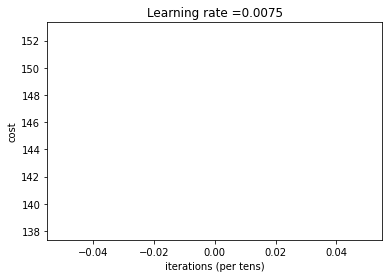

In [36]:
train(nn,x_train,y_train,print_cost=True)